In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
from tqdm import tqdm


Реализуем несколько методов первого порядка:

## SGD

In [2]:
def SGD(X, y, grad, lr=0.001, batch=10, num_iters=100):
    n, dim = np.shape(X)
    history = []
    
    batch = min(dim, batch)
    theta = np.zeros(dim)
    history.append(theta.copy())
    for it in range(1, num_iters + 1):
        ind = sps.randint(low=0, high=n).rvs(size=batch)
        sg = grad(X[ind, :], y[ind], theta).flatten()
        theta = theta - lr * sg
        history.append(theta.copy())
        
        
    return theta, history

## SGD with Momentum

In [3]:
def SGDM(X, y, grad, lr=0.001, batch=10, num_iters=100, momentum=0.2):
    n, dim = np.shape(X)
    history = []
    
    batch = min(dim, batch)
    theta = np.zeros(dim)
    mom_sg = np.zeros(dim)
    history.append(theta.copy())
    for it in range(1, num_iters + 1):
        ind = sps.randint(low=0, high=n).rvs(size=batch)
        sg = grad(X[ind, :], y[ind], theta).flatten()
        mom_sg = momentum * mom_sg + sg
        theta = theta - lr * mom_sg
        history.append(theta.copy())
        
    return theta, history

## RMSPROP

In [4]:
def RMSPROP(X, y, grad, lr=0.001, gamma=0.99, batch=10, num_iters=100):
    n, dim = np.shape(X)
    history = []
    
    batch = min(dim, batch)
    eps = 1e-8
    theta = np.zeros(dim)
    v = np.zeros(dim)
    history.append(theta.copy())
    for it in range(1, num_iters + 1):
        ind = sps.randint(low=0, high=n).rvs(size=batch)
        g = grad(X[ind, :], y[ind], theta).flatten()
        v = v * gamma + (1 - gamma) * g**2
        step = lr * g / (np.sqrt(v) + eps)
        theta -= step
        history.append(theta.copy())
    return theta, history

## ADAM

In [5]:
def ADAM(X, y, grad, lr=0.001, betas=(0.9, 0.999), batch=10, num_iters=100):
    n, dim = np.shape(X)
    history = []
    
    batch = min(dim, batch)
    eps = 1e-8
    beta1, beta2 = betas
    theta = np.zeros(dim)
    m = np.zeros(dim)
    v = np.zeros(dim)
    history.append(theta.copy())
    for it in range(1, num_iters + 1):
        ind = sps.randint(low=0, high=dim).rvs(size=batch)
        g = grad(X[ind, :], y[ind], theta).flatten()
        m = m * beta1 + g * (1 - beta1)
        v = v * beta2 + (1 - beta2) * g**2
        step = lr * m / (np.sqrt(v) + eps)
        theta -= step
        history.append(theta.copy())
    return theta, history

Посмотрим на их работу на МНК:
$$F(\theta)=\sum_{i=1}^{n}(x_i^T\theta - y_i)^2 \rightarrow \underset{\theta}{min}$$
Стохастический градиент:\
$$\triangledown F(\theta)= X_I^T(X_I\theta -Y_I)$$ где
$X_I$ строчки X с индексами из I, $Y_I$ строчки Y с индексами из I\
$I=\{i_1, ..., i_m \}\sim U\{1, ..., n\}$

In [6]:
n = 200
d = 5
theta0 = sps.expon.rvs(size=d)
X = sps.norm.rvs(size=(n, d))
y = X @ theta0

In [7]:
def func(X, y, theta):
    
    return np.linalg.norm(np.dot(X, theta) - y)**2

def grad(X, y, theta):
    m = np.shape(X)[0]
    return X.T @ (X@ theta - y)

In [8]:
_, history_SGD = SGD(X, y, grad, batch=20, num_iters=1000)
_, history_SGDM = SGDM(X, y, grad, batch=20, num_iters=1000)
_, history_RMSPROP = RMSPROP(X, y, grad, batch=20, lr=0.01, num_iters=1000)
_, history_ADAM = ADAM(X, y, grad, batch=20, lr=0.01, num_iters=1000)

In [9]:
def calculate_func(X, y, func, history):
    result = []
    for el in history:
        result.append(func(X, y, el))
    return result

In [10]:
result_SGD = calculate_func(X, y, func, history_SGD)
result_SGDM = calculate_func(X, y, func, history_SGDM)
result_RMSPROP = calculate_func(X, y, func, history_RMSPROP)
result_ADAM = calculate_func(X, y, func, history_ADAM)

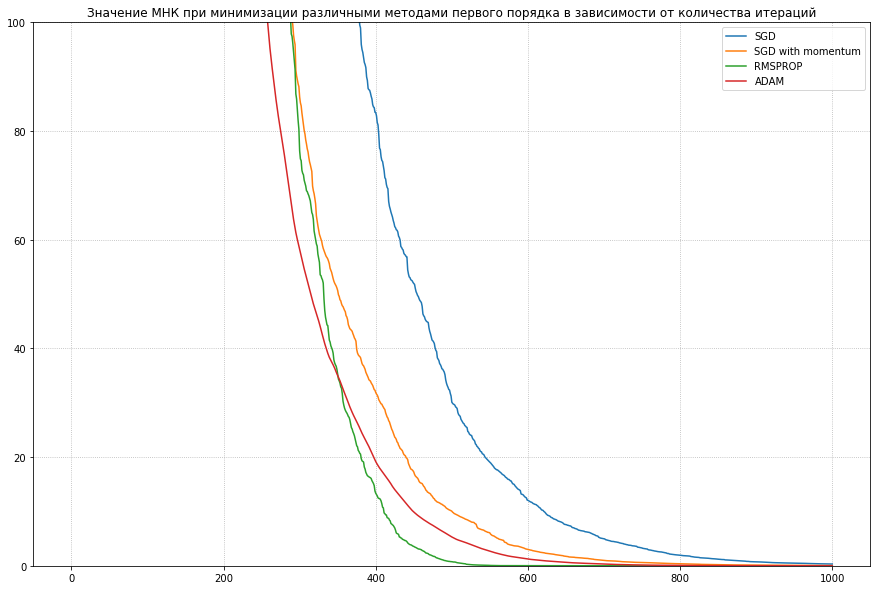

In [11]:
plt.figure(figsize=(15, 10))
plt.title('Значение МНК при минимизации различными методами первого порядка в зависимости от количества итераций')
grid = np.arange(0, len(result_SGD))

plt.plot(grid, result_SGD, label='SGD')
plt.plot(grid, result_SGDM, label='SGD with momentum')
plt.plot(grid, result_RMSPROP, label='RMSPROP')
plt.plot(grid, result_ADAM, label='ADAM')

plt.ylim((0, 100))
plt.grid(ls=':')
plt.legend()
plt.show()


Посмотрим теперь что изменится, если добавить первую норму. Задача перестанет быть гладкой:
$$F(\theta)=\sum_{i=1}^{n}(x_i^T\theta - y_i)^2 + \lambda \| \theta\|_1 \rightarrow \underset{\theta}{min}$$
Стохастический градиент:\
$$\triangledown F(\theta)= \frac{2n}{m}X_I^T(X_I\theta -Y_I) + \lambda sign(\theta)$$ где
$X_I$ строчки X с индексами из I, $Y_I$ строчки Y с индексами из I\
$I=\{i_1, ..., i_m \}\sim U\{1, ..., n\}$

In [22]:
n = 200
d = 5
theta0 = sps.expon.rvs(size=d)
X = sps.norm.rvs(size=(n, d))
y = X @ theta0

In [23]:
lambd = 1
def func(X, y, theta):
    
    return np.linalg.norm(np.dot(X, theta) - y)**2 + lambd * np.sum(np.abs(theta))

def grad(X, y, theta):
    m = np.shape(X)[0]
    return 2*n / m * X.T @ (X@ theta - y) + np.sign(theta) * lambd

In [24]:
_, history_SGD = SGD(X, y, grad, batch=20, num_iters=1000)
_, history_SGDM = SGDM(X, y, grad, batch=20, num_iters=1000)
_, history_RMSPROP = RMSPROP(X, y, grad, batch=20, lr=0.01, num_iters=1000)
_, history_ADAM = ADAM(X, y, grad, batch=20, lr=0.01, num_iters=1000)

In [25]:
result_SGD = calculate_func(X, y, func, history_SGD)
result_SGDM = calculate_func(X, y, func, history_SGDM)
result_RMSPROP = calculate_func(X, y, func, history_RMSPROP)
result_ADAM = calculate_func(X, y, func, history_ADAM)

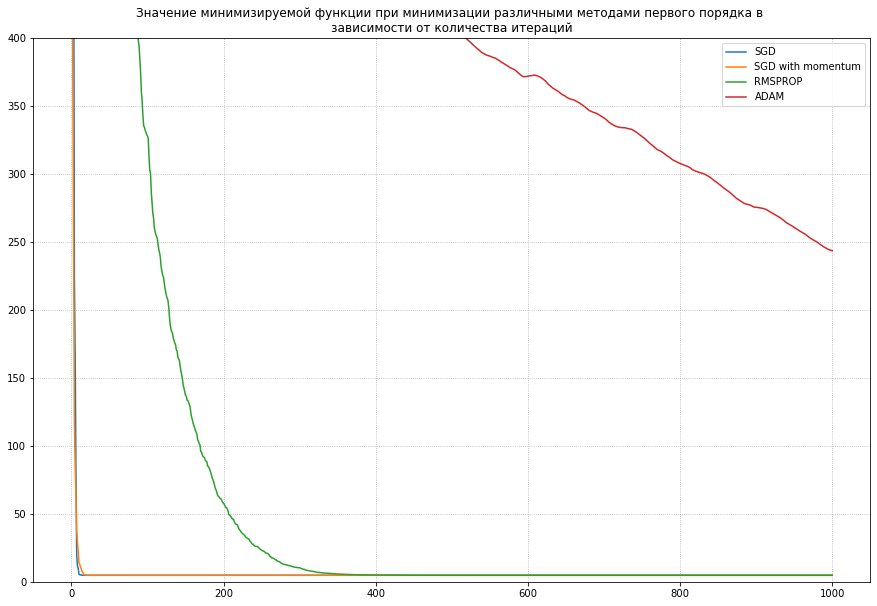

In [26]:
plt.figure(figsize=(15, 10))
plt.title('''Значение минимизируемой функции при минимизации различными методами первого порядка в 
зависимости от количества итераций''')
grid = np.arange(0, len(result_SGD))

plt.plot(grid, result_SGD, label='SGD')
plt.plot(grid, result_SGDM, label='SGD with momentum')
plt.plot(grid, result_RMSPROP, label='RMSPROP')
plt.plot(grid, result_ADAM, label='ADAM')

plt.grid(ls=':')
plt.ylim((0, 400))
plt.legend()
plt.show()